<a href="https://colab.research.google.com/github/BattalBAKINDI/MarketValueOfCentralForwardsInFootball/blob/main/central_striker_value_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Loading The Dataset And Necessary Libraries.**

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import sklearn.metrics as mt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [44]:
data = pd.read_csv("/content/drive/MyDrive/the_end_data.csv")
datacp = data.copy()

In [45]:
datacp

,Unnamed: 0,skill,pot_skill,name,age,value,height,weight,foot,minute,goal,asisst
0,0,92.2,100.0,Kylian Mbappé,24.0,146.8,178,75,Right,6293.0,57,31
1,1,93.2,100.0,Erling Haaland,22.0,139.0,195,88,Left,4326.0,54,11
2,2,93.9,100.0,Phil Foden,22.0,124.5,171,70,Left,4600.0,20,11
3,3,88.3,89.2,Harry Kane,29.0,89.8,188,86,Right,6296.0,35,13
4,4,91.7,93.9,Raheem Sterling,28.0,89.6,170,71,Right,4745.0,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...
711,698,55.3,55.3,Jaime Mata,34.0,1.5,186,79,Right,842.0,1,0
712,702,55.7,67.0,Max Fenger,21.0,1.5,182,75,Right,1855.0,6,0
713,706,53.9,54.2,Ernesto Torregrossa,30.0,1.4,184,80,Left,1889.0,12,3
714,707,52.8,62.2,Mikael,23.0,1.4,184,85,Both,1679.0,4,0


**skill:** is the current ability of the player.

**pot-skill:** the potential skill of the football player.

**name:** is the name of the player.

**age:** is the age of the player.

**value:** is the market value of the player.

**height:** is the length of the player in cm.

**weight:** is the weight of the player in kg.

**foot:** It is the foot that the player uses strongly.

**minute:** The time the player played in 1.5 seasons.

**assist:** The number of assists the player has made in 1.5 seasons.

**goals:** The number of goals the player has made in 1.5 seasons.




In [46]:
datacp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  716 non-null    int64  
 1   skill       716 non-null    float64
 2   pot_skill   716 non-null    float64
 3   name        716 non-null    object 
 4   age         716 non-null    float64
 5   value       716 non-null    float64
 6   height      716 non-null    int64  
 7   weight      716 non-null    int64  
 8   foot        716 non-null    object 
 9   minute      716 non-null    float64
 10  goal        716 non-null    int64  
 11  asisst      716 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 67.2+ KB


* The only column in the data that is in the object structure is foot

In [47]:
datacp.isnull().sum()

Unnamed: 0    0
skill         0
pot_skill     0
name          0
age           0
value         0
height        0
weight        0
foot          0
minute        0
goal          0
asisst        0
dtype: int64

* There are no missing values in the data.

In [48]:
datacp.drop_duplicates(inplace=True)

In [49]:
datacp.drop(columns=["Unnamed: 0"],inplace = True)

# 2) EDA & Feature Engineering

In [50]:
datacp["score_contribution"] = datacp.goal + datacp.asisst
datacp["score_efficiency"] = datacp.score_contribution / datacp.minute
datacp["assists_efficiency"] = datacp.asisst / datacp.minute
datacp["goal_efficiency"] = datacp.goal / datacp.minute
datacp["development"] = datacp.pot_skill - datacp.skill
datacp["body_mass_index"] = datacp.weight / ((datacp.height/100)**2)


* Body mass index (BMI) or height weight index; It is a calculation method that shows the estimated fat percentage in a person's body. Body mass index has a direct effect on fitness and physical quality in athletes.
* some players are limited to their current abilities, while others are more open to development, which is reflected in their market value. We have created a new column called development by subtracting current abilities from potential abilities.
* The effect of a central striker on the score is very important in the unit time he plays. We have created extra columns for score, goal and assist efficiency.


In [51]:
datacp

,skill,pot_skill,name,age,value,height,weight,foot,minute,goal,asisst,score_contribution,score_efficiency,assists_efficiency,goal_efficiency,development,body_mass_index
0,92.2,100.0,Kylian Mbappé,24.0,146.8,178,75,Right,6293.0,57,31,88,0.013984,0.004926,0.009058,7.8,23.671254
1,93.2,100.0,Erling Haaland,22.0,139.0,195,88,Left,4326.0,54,11,65,0.015025,0.002543,0.012483,6.8,23.142669
2,93.9,100.0,Phil Foden,22.0,124.5,171,70,Left,4600.0,20,11,31,0.006739,0.002391,0.004348,6.1,23.938990
3,88.3,89.2,Harry Kane,29.0,89.8,188,86,Right,6296.0,35,13,48,0.007624,0.002065,0.005559,0.9,24.332277
4,91.7,93.9,Raheem Sterling,28.0,89.6,170,71,Right,4745.0,22,10,32,0.006744,0.002107,0.004636,2.2,24.567474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,55.3,55.3,Jaime Mata,34.0,1.5,186,79,Right,842.0,1,0,1,0.001188,0.000000,0.001188,0.0,22.835010
712,55.7,67.0,Max Fenger,21.0,1.5,182,75,Right,1855.0,6,0,6,0.003235,0.000000,0.003235,11.3,22.642193
713,53.9,54.2,Ernesto Torregrossa,30.0,1.4,184,80,Left,1889.0,12,3,15,0.007941,0.001588,0.006353,0.3,23.629490
714,52.8,62.2,Mikael,23.0,1.4,184,85,Both,1679.0,4,0,4,0.002382,0.000000,0.002382,9.4,25.106333


FOOT

In [52]:
datacp.foot.value_counts()

Right    560
Left     118
Both      38
Name: foot, dtype: int64

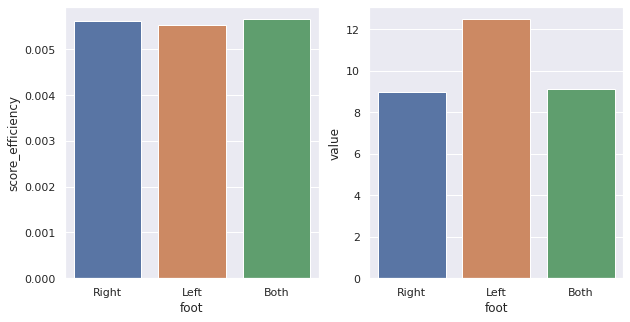

In [53]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
sns.set()
sns.barplot(data=datacp, x='foot', y='score_efficiency', ax=axes[0], ci=0)
sns.barplot(data=datacp, x='foot', y='value', ax=axes[1], ci=0)

* Although their contribution to the score is the same, left-footed forwards are more expensive because they are rarer.
* For strikers who use both feet, the strongest foot is mostly the right foot.

AGE

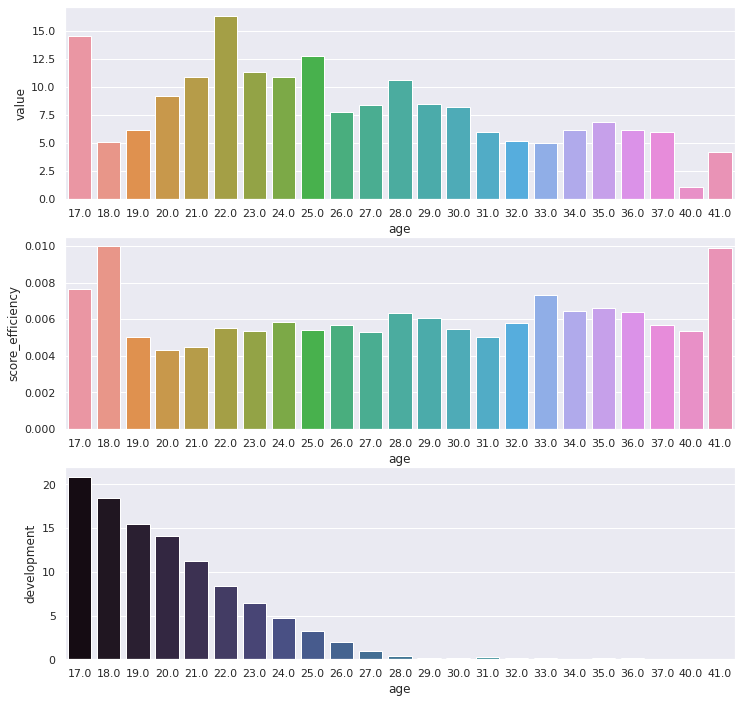

In [54]:
fig, axes = plt.subplots(3, 1,figsize=(12,12))
sns.set()
sns.barplot(data=datacp, x='age', y='value', ax=axes[0], ci=0)
sns.barplot(data=datacp, x='age', y='score_efficiency', ax=axes[1], ci=0)
sns.barplot(data=datacp, x='age', y='development', ax=axes[2], ci=0, palette="mako")

COMMENTS FROM THE GRAPHICS:
* The market value of strikers in the 20-29 age range is higher.
* The reason why football players aged 17, 18 contribute to the score is due to the fact that they play in the A2 teams of their clubs.
* As players get older, their development decreases.

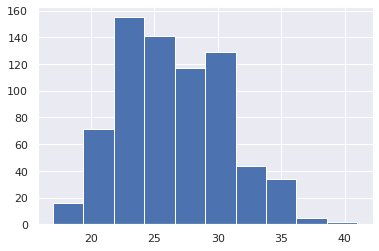

In [82]:
datacp.age.hist()

* The distribution of the age attribute is similar to the normal distribution.

POT_SKİLL

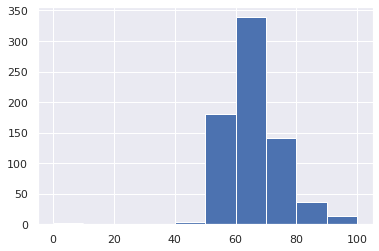

In [56]:
datacp.pot_skill.hist()

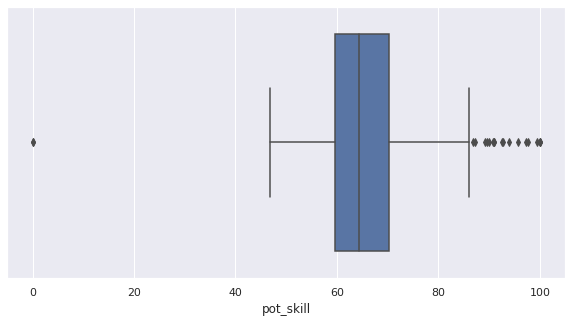

In [57]:
plt.figure(figsize=[10,5])
sns.boxplot(x=datacp['pot_skill'], data=datacp);

* the potential skill of any striker cannot be zero, we can remove the outlier from our data.

In [58]:
datacp = datacp.loc[datacp['pot_skill'] >= 40]

MİNUTE

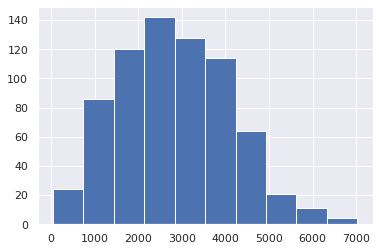

In [59]:
datacp.minute.hist()

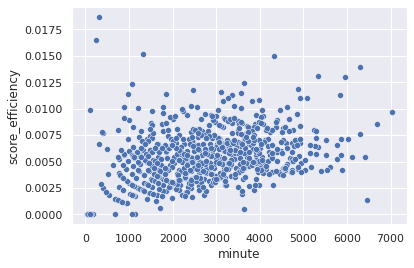

In [60]:
sns.scatterplot(x="minute", y="score_efficiency", data=datacp)

* As the time played by the strikers increases, the score efficiency increases.

## **3)Preparing the data for the model**

In [61]:
datacp = pd.get_dummies(datacp, columns=['foot'], drop_first=True)

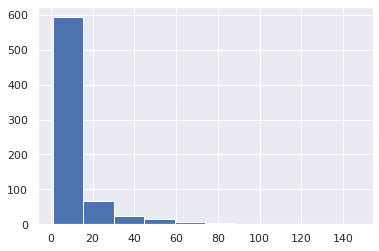

In [62]:
datacp.value.hist()

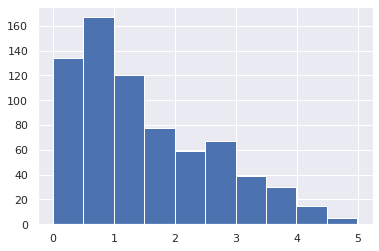

In [63]:
datacp['log_value'] = np.log(datacp.value)
datacp.log_value.hist();

* The value attribute has a right-skewed distribution, we correct the distribution with logarithms.

In [64]:
datacp

,skill,pot_skill,name,age,value,height,weight,minute,goal,asisst,score_contribution,score_efficiency,assists_efficiency,goal_efficiency,development,body_mass_index,foot_Left,foot_Right,log_value
0,92.2,100.0,Kylian Mbappé,24.0,146.8,178,75,6293.0,57,31,88,0.013984,0.004926,0.009058,7.8,23.671254,0,1,4.989071
1,93.2,100.0,Erling Haaland,22.0,139.0,195,88,4326.0,54,11,65,0.015025,0.002543,0.012483,6.8,23.142669,1,0,4.934474
2,93.9,100.0,Phil Foden,22.0,124.5,171,70,4600.0,20,11,31,0.006739,0.002391,0.004348,6.1,23.938990,1,0,4.824306
3,88.3,89.2,Harry Kane,29.0,89.8,188,86,6296.0,35,13,48,0.007624,0.002065,0.005559,0.9,24.332277,0,1,4.497585
4,91.7,93.9,Raheem Sterling,28.0,89.6,170,71,4745.0,22,10,32,0.006744,0.002107,0.004636,2.2,24.567474,0,1,4.495355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,55.3,55.3,Jaime Mata,34.0,1.5,186,79,842.0,1,0,1,0.001188,0.000000,0.001188,0.0,22.835010,0,1,0.405465
712,55.7,67.0,Max Fenger,21.0,1.5,182,75,1855.0,6,0,6,0.003235,0.000000,0.003235,11.3,22.642193,0,1,0.405465
713,53.9,54.2,Ernesto Torregrossa,30.0,1.4,184,80,1889.0,12,3,15,0.007941,0.001588,0.006353,0.3,23.629490,1,0,0.336472
714,52.8,62.2,Mikael,23.0,1.4,184,85,1679.0,4,0,4,0.002382,0.000000,0.002382,9.4,25.106333,0,0,0.336472


In [66]:
datacp.drop(columns=["name","value"],inplace=True)

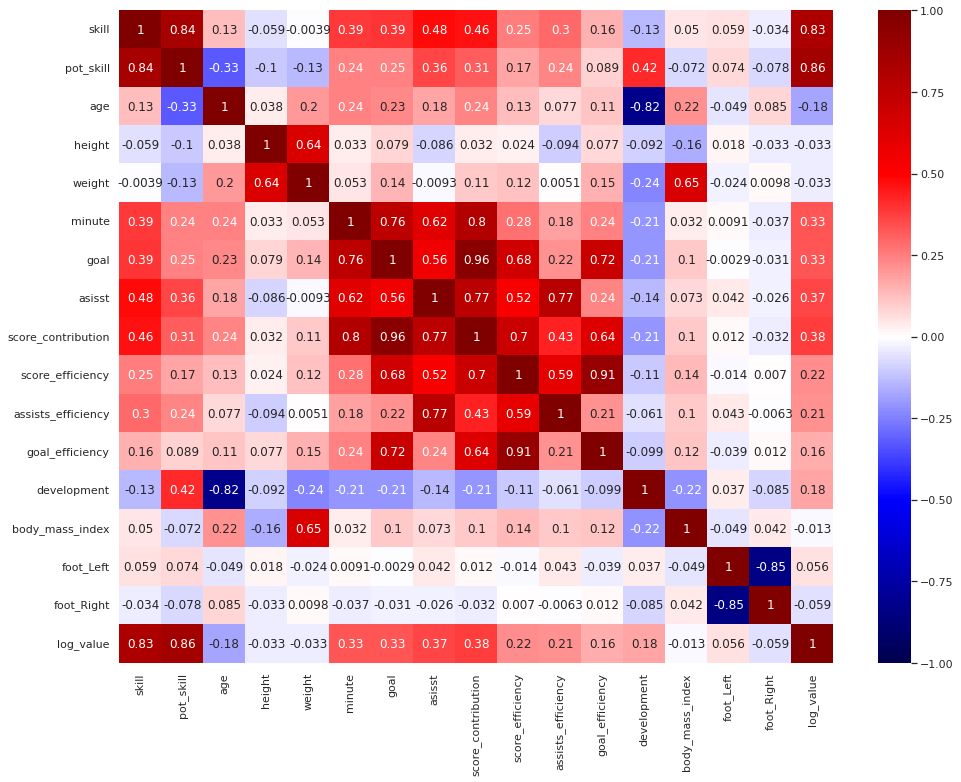

In [67]:
plt.figure(figsize=[16,12])
sns.heatmap(datacp.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

* We are removing the goal and goal efficiency attributes from our data due to the multicollinearity problem.

In [68]:
datacp.drop(columns=["goal","goal_efficiency"], axis=1, inplace=True)

In [69]:
X = datacp.drop(columns='log_value')
y = datacp.log_value
X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X, y = np.array(X), np.array(y)

In [70]:
scaler = StandardScaler()
sm_X_train = scaler.fit_transform(X)

In [71]:

X_sm = sm.add_constant(sm_X_train)
lsm = sm.OLS(y,X_sm)
fit4 = lsm.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     164.2
Date:                Thu, 02 Feb 2023   Prob (F-statistic):          7.96e-181
Time:                        11:59:39   Log-Likelihood:                -427.69
No. Observations:                 571   AIC:                             883.4
Df Residuals:                     557   BIC:                             944.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5113      0.022     69.700      0.000       1.469       1.554
x1             0.5392      0.018     30.407      0.000       0.504       0.574
x2             0.4694      0.015     31.743      0.000       0.440       0.498
x3            -0.1776      0.039     -4.613      0.000      -0.253      -0.102
x4            -0.1140      0.329     -0.347      0.729      -0.760       0.532
x5             0.1944      0.425      0.458      0.647      -0.640       1.029
x6             0.2014      0.049      4.131      0.000       0.106       0.297
x7             0.0707      0.075      0.946      0.344      -0.076       0.218
x8            -0.2386      0.092     -2.596      0.010      -0.419      -0.058
x9             0.1826      0.056      3.262      0.001       0.073       0.293
x10           -0.1167      0.058     -1.998      0.046      -0.231      -0.002
x11           -0.0367      0.034     -1.093      0.275      -0.103       0.029
x12           -0.1314      0.327     -0.401      0.688      -0.775       0.512
x13           -0.0515      0.042     -1.230      0.219      -0.134       0.031
x14           -0.0437      0.042     -1.035      0.301      -0.127       0.039
==============================================================================
Omnibus:                        7.265   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.446
Skew:                           0.221   Prob(JB):                       0.0242
Kurtosis:                       3.344   Cond. No.                     1.06e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## **4) Train models with our data**

VALIDATION RESULTS AND MODEL SELECTION

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

linear_model_r2 = []
ridge_model_r2 = []
lasso_model_r2 = []
dtr_model_r2 = []
svr_model_r2 = []
rfr_model_r2 = []
xgboost_model_r2 =[]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    linear_model = LinearRegression()
    ridge_model = Ridge(alpha=7.31)
    lasso_model = Lasso()
    dtr_model = DecisionTreeRegressor()
    svr_model = SVR()
    rfr_model = RandomForestRegressor()
    xgboost_model = GradientBoostingRegressor()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    linear_model.fit(X_train_scaled, y_train)
    linear_model_r2.append(round(linear_model.score(X_val_scaled, y_val),3))
    
    ridge_model.fit(X_train_scaled, y_train)
    ridge_model_r2.append(round(ridge_model.score(X_val_scaled, y_val),3))

    lasso_model.fit(X_train_scaled, y_train)
    lasso_model_r2.append(round(lasso_model.score(X_val_scaled, y_val),3))

    dtr_model.fit(X_train_scaled, y_train)
    dtr_model_r2.append(round(dtr_model.score(X_val_scaled, y_val),3))

    svr_model.fit(X_train_scaled, y_train)
    svr_model_r2.append(round(svr_model.score(X_val_scaled, y_val),3))

    rfr_model.fit(X_train_scaled, y_train)
    rfr_model_r2.append(round(rfr_model.score(X_val_scaled, y_val),3))

    xgboost_model.fit(X_train_scaled, y_train)
    xgboost_model_r2.append(round(xgboost_model.score(X_val_scaled, y_val),3))

print('Linear Regression R2:', linear_model_r2)
print('Ridge Regression R2:', ridge_model_r2, '\n')
print("lasso Regression R2:", lasso_model_r2, "\n")
print("decision tree Regression:", dtr_model_r2, "\n")
print("support vector Regression:", svr_model_r2, "\n")
print("random forest Regression:", svr_model_r2,"\n")
print("xgboost Regression:", xgboost_model_r2, "\n")

print(f'Linear Regression R2: {np.mean(linear_model_r2):.3f} +- {np.std(linear_model_r2):.3f}')
print(f'Ridge Regression R2: {np.mean(ridge_model_r2):.3f} +- {np.std(ridge_model_r2):.3f}')
print(f'lasso Regression R2: {np.mean(lasso_model_r2):.3f} +- {np.std(lasso_model_r2):.3f}')
print(f'decision tree Regression: {np.mean(dtr_model_r2):.3f} +- {np.std(dtr_model_r2):.3f}')
print(f'support vector Regression: {np.mean(svr_model_r2):.3f} +- {np.std(svr_model_r2):.3f}')
print(f'random forest Regression: {np.mean(rfr_model_r2):.3f} +- {np.std(rfr_model_r2):.3f}')
print(f'xgboost Regression: {np.mean(xgboost_model_r2):.3f} +- {np.std(xgboost_model_r2):.3f}')

Linear Regression R2: [0.75, 0.736, 0.778, 0.798, 0.803]
Ridge Regression R2: [0.759, 0.74, 0.776, 0.796, 0.804] 

lasso Regression R2: [-0.007, -0.0, -0.003, -0.017, -0.001] 

decision tree Regression: [0.592, 0.583, 0.629, 0.701, 0.638] 

support vector Regression: [0.767, 0.752, 0.694, 0.76, 0.796] 

random forest Regression: [0.767, 0.752, 0.694, 0.76, 0.796] 

xgboost Regression: [0.757, 0.798, 0.819, 0.819, 0.835] 

Linear Regression R2: 0.773 +- 0.026
Ridge Regression R2: 0.775 +- 0.024
lasso Regression R2: -0.006 +- 0.006
decision tree Regression: 0.629 +- 0.042
support vector Regression: 0.754 +- 0.033
random forest Regression: 0.798 +- 0.024
xgboost Regression: 0.806 +- 0.027


* After applying the cross validation process to our data and training 7 different models with our data, the xgboost model gave the most successful result.

* Lasso model structure, not suitable for our data.

**HYPERPARAMETER OPTIMIZATION AND TEST RESULTS**

* Before giving test data to our most successful models, hyper-parameter optimization was performed with GridSearchCv.

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test.values)

In [74]:
rdg_model = Ridge(alpha=7.43)
xgb_model = GradientBoostingRegressor(max_depth= 3, n_estimators= 53)

In [75]:
parameters = {"alpha":10**(np.linspace(-2,8,600))}
parameters_xgb = {"n_estimators": range(10,55), "max_depth": range(1,15)}

In [ ]:
grid = GridSearchCV(estimator=rdg_model,param_grid=parameters,cv=10)
grid.fit(X_train_scaled,y)
print(grid.best_params_)

grid_xgb = GridSearchCV(estimator=xgb_model,param_grid=parameters_xgb,cv=8)
grid_xgb.fit(X_train_scaled,y)
print(grid_xgb.best_params_)

{'alpha': 7.437935718532088}
{'max_depth': 3, 'n_estimators': 53}


In [76]:
xgb_model.fit(X_train_scaled,y)
predict_xgb = xgb_model.predict(X_test_scaled)

rdg_model.fit(X_train_scaled,y)
predict = rdg_model.predict(X_test_scaled)

In [77]:
print("ridge_score:", r2_score(y_test,predict))
print("xgb_score:", r2_score(y_test,predict_xgb))


ridge_score: 0.7621797668950052
xgb_score: 0.8121340246427251


* Success rate of ridge regression and xgboost models on test data after hyper parameter optimization.

ACTUAL VALUES AND OUR ESTIMATED VALUES

In [128]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': (predict_xgb)})
df['Actual'] = np.expm1(df['Actual'])
df['Predicted'] = np.expm1(df['Predicted'])
df_ = df[83:89]

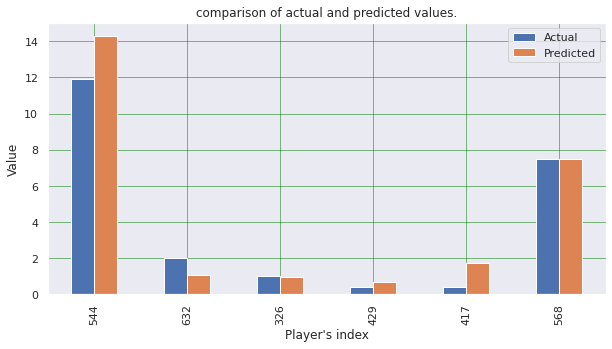

In [130]:

df_[["Actual","Predicted"]].plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("comparison of actual and predicted values.")
plt.xlabel("Player's index")
plt.ylabel('Value')
plt.show()